# Workflow Debugging

0.8791208791208791
Compilation paths from Train Data:  {0, 1, 3, 7, 11, 12}
Compilation paths from Test Data:  {0, 1, 3, 7, 11, 12}
Compilation paths from Predictions:  {0, 1, 3, 7, 11, 12}


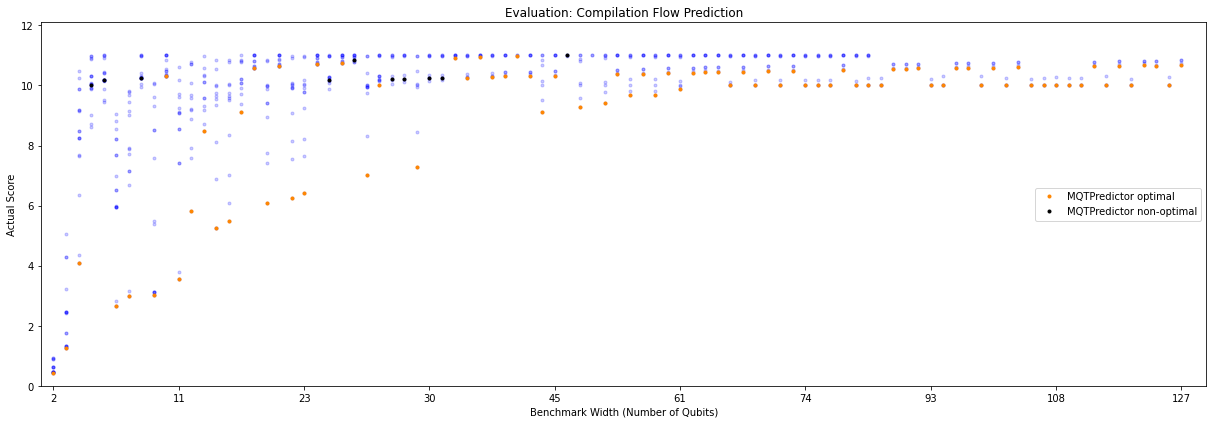

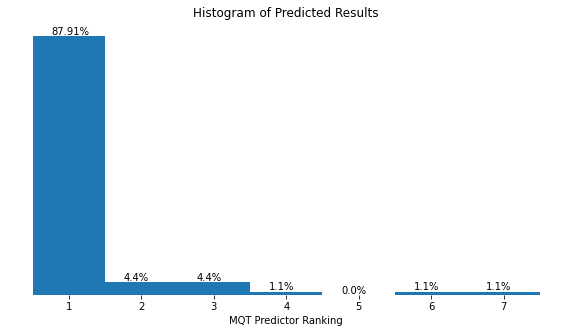

sum:  100.00999999999999


In [2]:
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split


training_data, names_list, scores_list = Predictor.generate_trainingdata_from_json("part1file.json")
#print(training_data, names_list, scores_list)
X, y = zip(*training_data)
X = np.array(X)
y = np.array(y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# non_zero_indices = []
# for i in range(len(X[0])):
#    if sum(X[:,i]) > 0:
#        non_zero_indices.append(i)
# X = X[:, non_zero_indices]
openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")
features = list(np.sort(np.array(res)))
#features = features[non_zero_indices]
# print(features)


# scaler = preprocessing.StandardScaler().fit(X)
# X = preprocessing.normalize(X, norm='l2')
# X = scaler.transform(X)

Predictor.train_decision_tree_classifier(X,y, names_list, scores_list, max_depth=5);

In [14]:
print(X.shape)
index = 302
print(len(scores_list[index]), scores_list[index])

(303, 43)
19 [1000000, 10.004789333685325, 1000000, 1000000, 1000000, 1000000, 10.288841244950166, 1000000, 1000000, 1000000, 1000000, 10.00478933333974, 1000000, 1000000, 1000000, 10.004789333679373, 1000000, 1000000, 1000000]


# Parameter Gridsearch

In [ ]:
import matplotlib.pyplot as plt
from predictor.src import utils
from sklearn.tree import plot_tree
from sklearn import tree

X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))
(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=42)

clf_instance = tree.DecisionTreeClassifier()



In [ ]:
from sklearn.model_selection import GridSearchCV
tree_param = [{'criterion': ['entropy', 'gini'], 
              'max_depth': [i for i in range(1,15,1)],
              'min_samples_split': [i for i in range(2,20,2)],
              'min_samples_leaf': [i for i in range(2,20,2)],
              'max_leaf_nodes': [i for i in range(2,200, 20)],
              'max_features': [i for i in range(1,45,5)]},
             ]
clf = GridSearchCV(clf_instance, tree_param, cv=5)
clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)

# Decision Path Generation

In [ ]:
clf_instance.fit(X_train, y_train)
n_nodes = clf_instance.tree_.node_count
children_left = clf_instance.tree_.children_left
children_right = clf_instance.tree_.children_right
feature = clf_instance.tree_.feature
threshold = clf_instance.tree_.threshold
node_indicator = clf_instance.decision_path(X_test)
leaf_id = clf_instance.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue
    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=features[feature[node_id]],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

# Other Tree Plot Types

In [ ]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(23, 5))
clf = Predictor._clf


from dtreeviz.trees import dtreeviz # remember to load the package
machines = [
        "qiskit_ibm_washington",
        "qiskit_ibm_montreal",
        "qiskit_ionq",
        "qiskit_rigetti",
        "qiskit_oqc",
        "tket_ibm_washington",
        "tket_ibm_montreal",
        "tket_ionq",
        "tket_rigetti",
        "tket_oqc",
    ]
openqasm_gates_list = utils.get_openqasm_gates()
res = [openqasm_gates_list[i] for i in range(0, len(openqasm_gates_list))]
res.append("num_qubits")
features = np.sort(np.array(res))

X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))
(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=42)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)
viz = dtreeviz(clf, 
               X_train, 
               y_train,
               target_name="target",
               feature_names=features,
               class_names=machines,
               fancy=True
)
viz.save_svg()
viz


In [ ]:
import graphviz
clf = tree.DecisionTreeClassifier(max_depth=10)
clf = clf.fit(X_train, y_train)
dot_data = tree.export_graphviz(clf, out_file=None, 
               feature_names=features,
               class_names=machines,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render("graphviz")

In [ ]:
a = [2,5]

In [ ]:
np.where(np.array(a) >= 8)[0][0]

In [ ]:
from mqt.bench import get_one_benchmark

In [ ]:
qc1 = get_one_benchmark("qwalk-v-chain",1,6)
qc1.draw()
print(qc1.num_qubits)

In [ ]:
from pytket.extensions.qiskit import qiskit_to_tk
from qiskit.compiler import transpile
from qiskit import QuantumCircuit

In [ ]:
qc3 = QuantumCircuit.from_qasm_file("qasm_vchain/grover-v-chain_indep_11.qasm")
qc4 = get_one_benchmark("grover-v-chain",1,8)

In [ ]:
print(qc3.count_ops())
print(qc4.count_ops())

In [ ]:
from pytket.qasm import circuit_from_qasm
qc5 = QuantumCircuit.from_qasm_file("qasm_vchain/grover-v-chain_indep_3.qasm")
qiskit_to_tk(qc5)
#qc6 = circuit_from_qasm("qasm_vchain/grover-v-chain_indep_3.qasm")
#qiskit_to_tk(qc5)